# Shape classification

## Task

Network predicts six numbers: probabilities of a class being found on the image (in at least one copy). Loss function is the sum of loglosses over all classes:
$$J = -\sum_{j=0}^5y_i*log(\hat y_i)+(1-y_i)*log(1-\hat y_i)$$ *Notation:* $y_i$ is a ground truth, $\hat y_i$ is predicted probability of class $i$ on the image.

## Network

At first I created a pretty big convolutional network.

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class ShapesClassifier(nn.Module):
    def __init__(self):
        super(ShapesClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=(2, 2),
                      padding=(1, 1)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(4, 4),
                      padding=(1, 1)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.ReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=400,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=400,
                      out_channels=100,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.ReLU()
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=100,
                      out_channels=40,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(360, 200),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(200, 80),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(80, 6)
        )

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_training(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    x = np.arange(len(run_hist["train/loss"])) + 1
    ax[0].plot(x, run_hist["train/loss"], 'b', marker='.', label="epoch train loss")
    ax[0].plot(x, run_hist["validation/loss"], 'r', marker='.', label="epoch test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["train/acc"], 'b', marker='.', label="epoch train accuracy")
    ax[1].plot(x, run_hist["validation/acc"], 'r', marker='.', label="epoch test accuracy")
    ax[1].legend()

    fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)
    x = np.arange(len(run_hist["train/batch_loss"])) + 1
    ax.plot(x, run_hist["train/batch_loss"], 'b', marker='.', label="batch train loss")
    ax.legend()

    

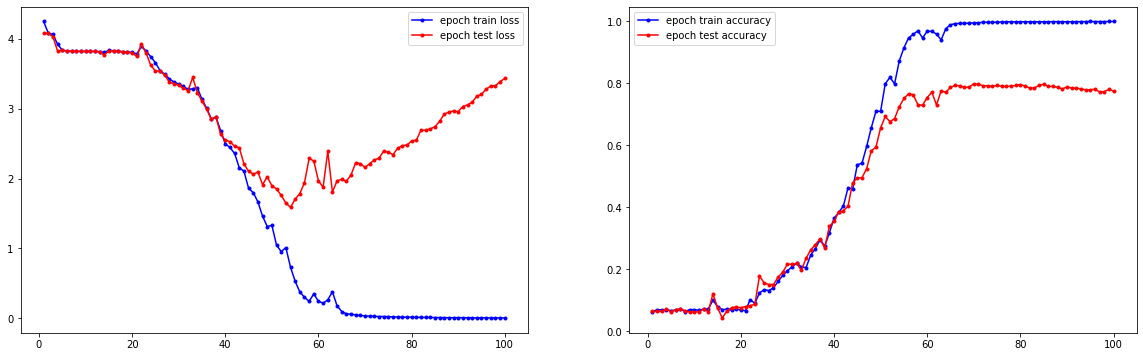

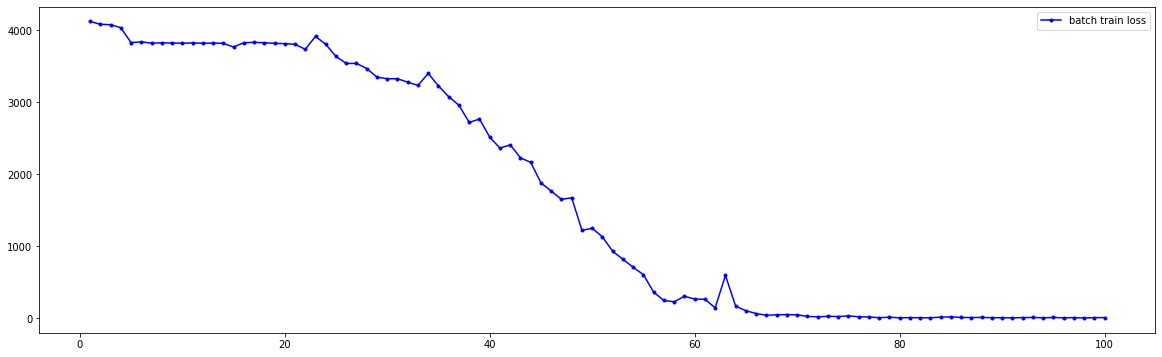

In [19]:
with open('charts/classifier/convnet.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

Unfortunately, after training we can see two problems:
1. Overfitting
2. Long training time (stuck at 6% accuracy for over 20 epochs)

We can try adding more data to fight the first problem.

## Augmentation

We have 4 operations

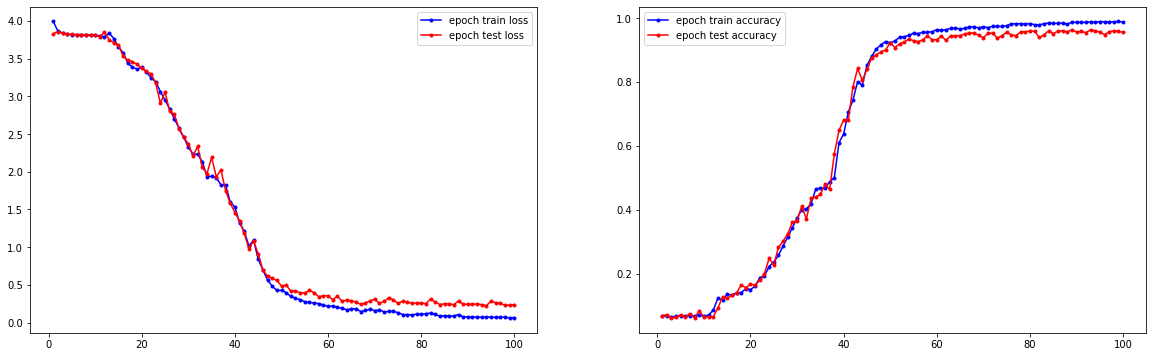

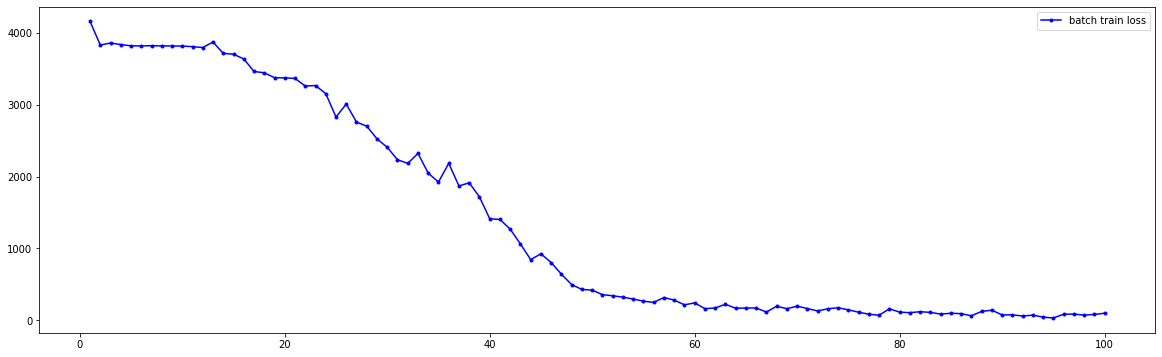

In [25]:
with open('charts/classifier/raw_augmentation.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

Now we can achieve 99% accuracy on the training set, and 96% accuracy on the validation set. This is pretty good, but maybe the learning curve can be improved.

## Batch normalization

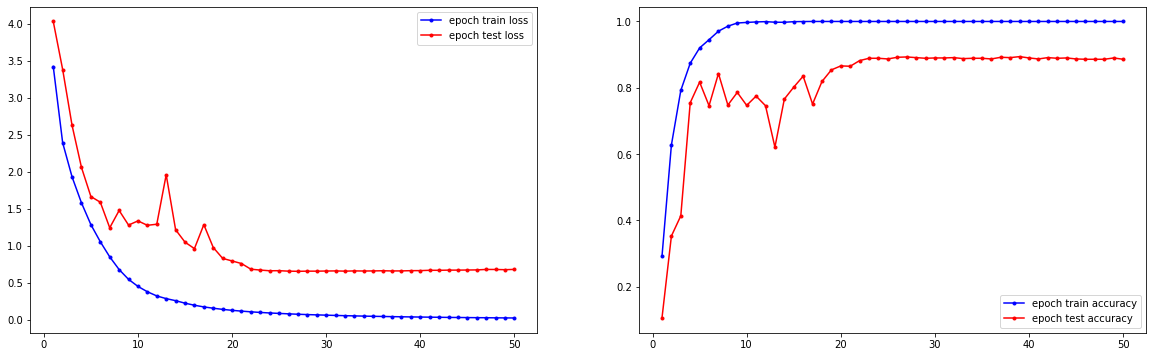

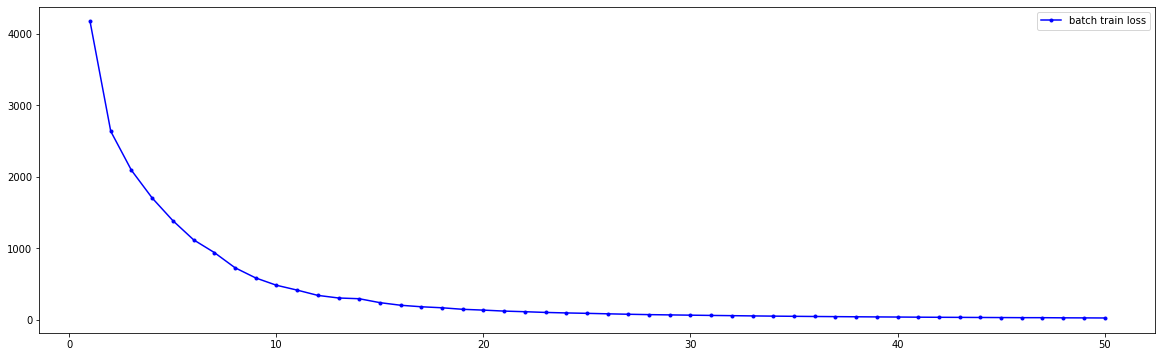

In [17]:
with open('charts/classifier/batch_norm.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

## Batch normalization with augmentation

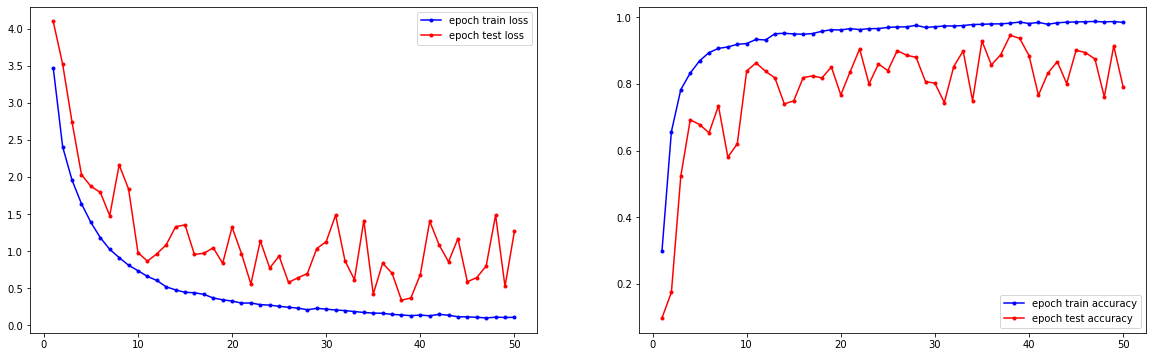

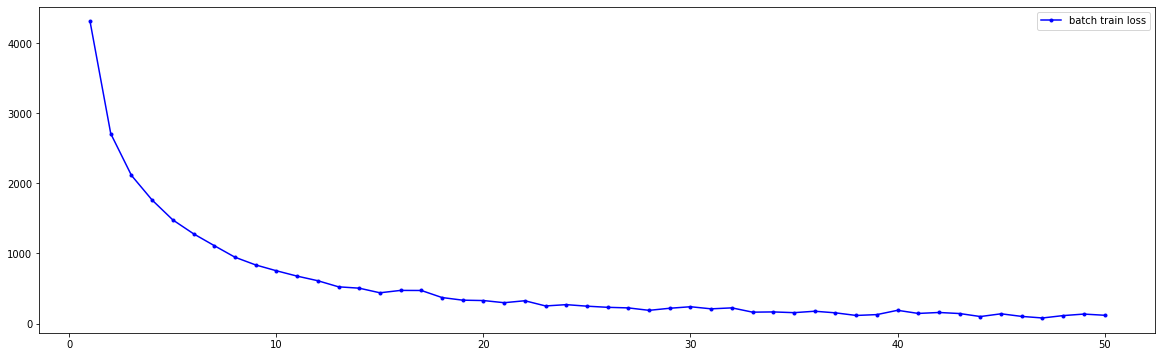

In [21]:
with open('charts/classifier/batch_with_aug.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

Right now we're overfitting, let's try smaller model.

## Smaller network

In [29]:
import torch.nn as nn
import torch.nn.functional as F


class ShapesClassifier(nn.Module):
    def __init__(self):
        super(ShapesClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=16,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2, 2)),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=(3, 3),
                      padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=(5, 5),
                      stride=(2, 2),
                      padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(7, 7),
                      stride=(5, 5),
                      padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128, 100),
            nn.BatchNorm1d(100),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(50, 6)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


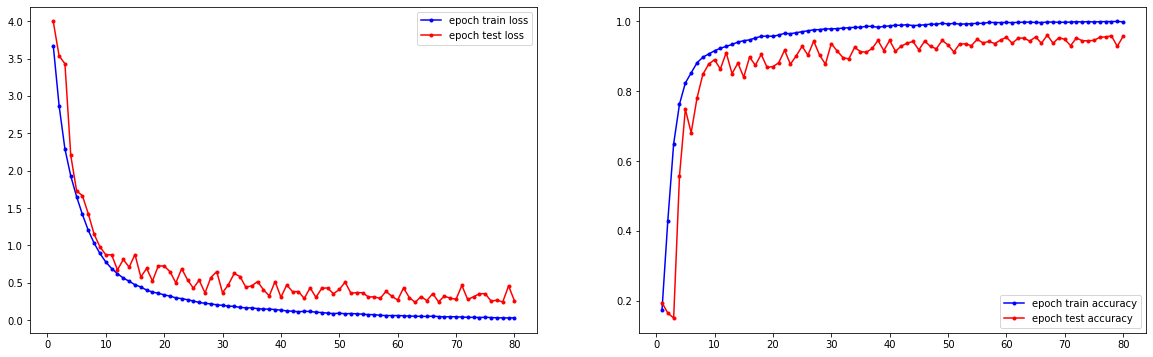

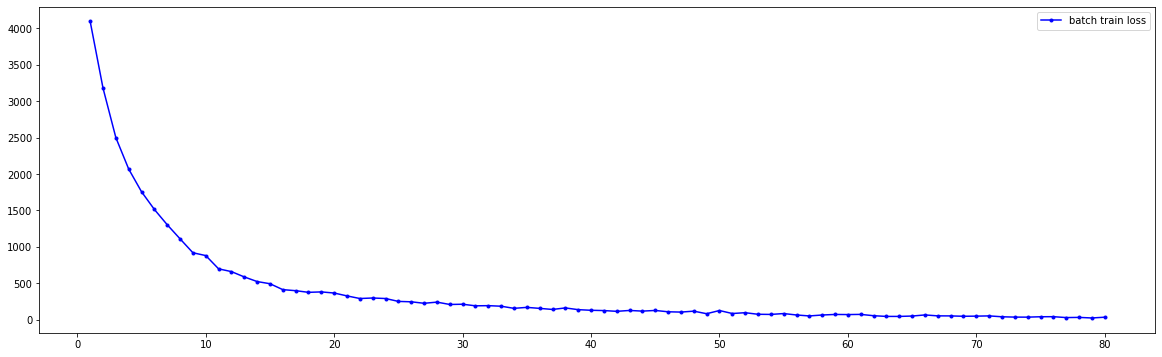

In [27]:
with open('charts/classifier/smaller_model.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

Network is overfitting now, let's add dropout.

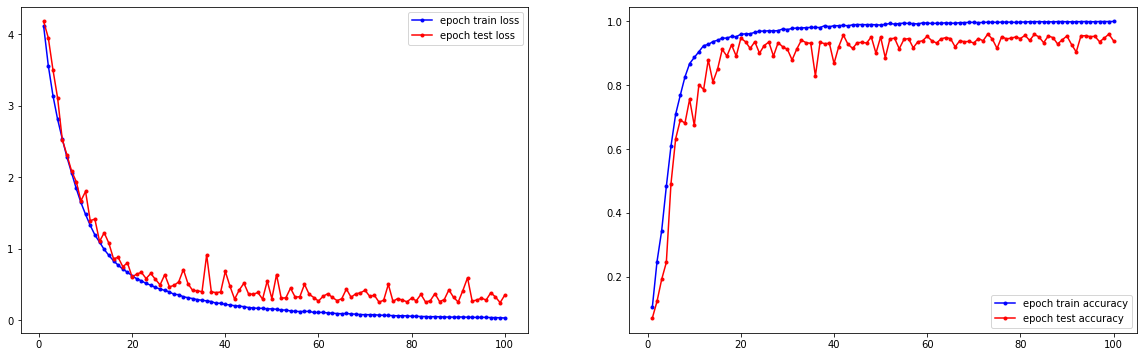

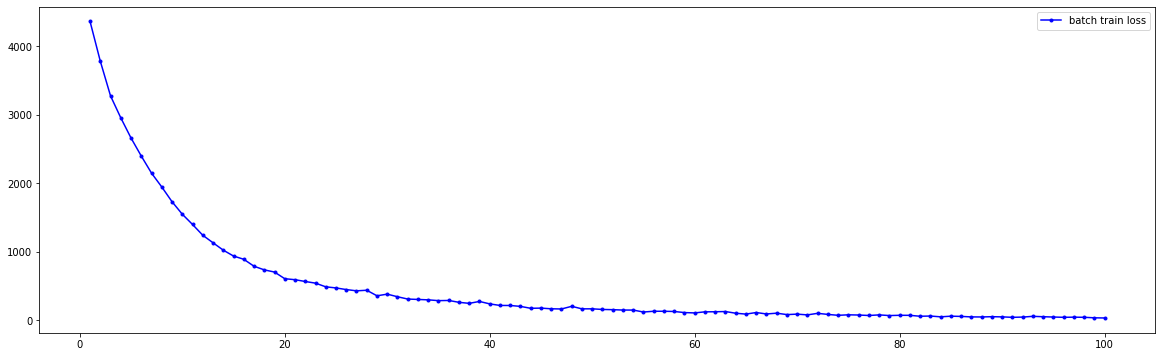

In [28]:
with open('charts/classifier/dropout.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

Dropout didn't help

## Batch Normalization part 2

After reading [this article](http://luiz.hafemann.ca/reviews/2016/02/19/notes-on-batch-normalization/) I thought about adding batch normalization after last linear layer.

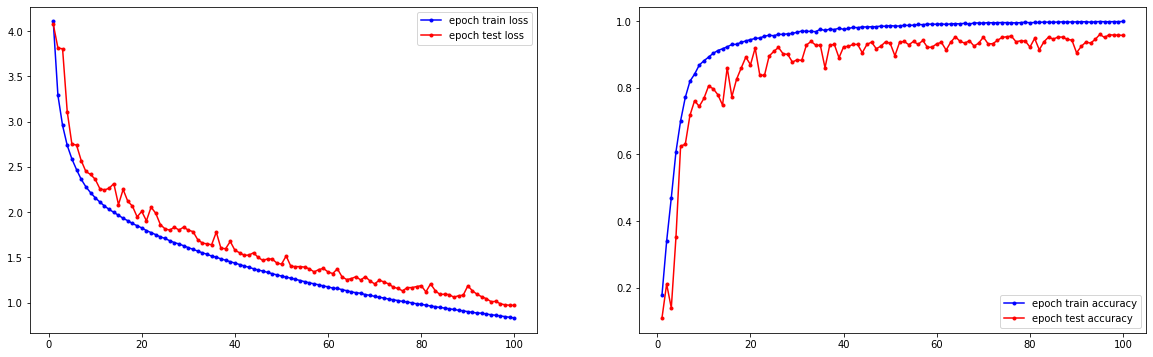

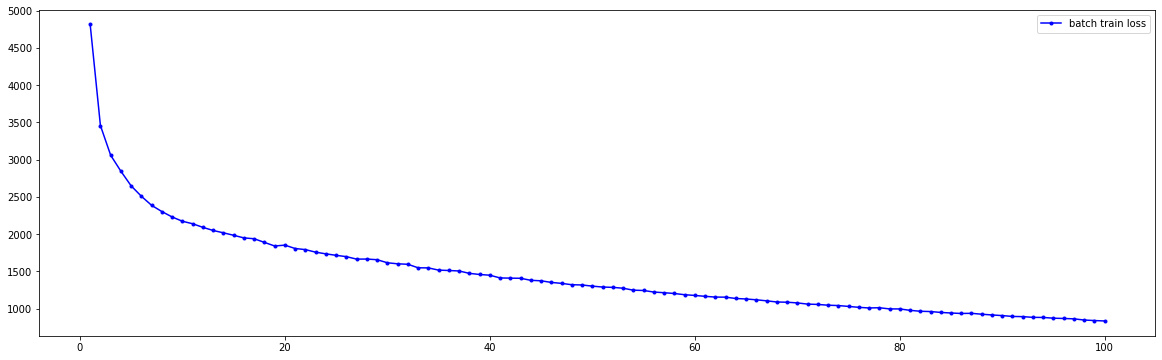

In [3]:
with open('charts/classifier/bn_last_layer.json', 'r') as f:
    hist = json.loads(f.read())
    plot_training(hist)

## Confusion matrix

In [3]:
import torch

model = torch.load('classifier.pt')
model.eval()

ShapesClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(5, 5), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=128, out_f

In [4]:
from datasets.shapes_dataset import ShapesClassificationDataset
from sklearn.metrics import multilabel_confusion_matrix

import torchvision.transforms as transforms

transform_images = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

validation_set = ShapesClassificationDataset(
    "data/val.csv",
    "data/images",
    transform_all=None,
    transform_images=transform_images
)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1000,
                                                shuffle=False, num_workers=1)

classes = ('squares', 'circles', 'triangle_up', 'triangle_right',
           'triangle_down', 'triangle_left')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    
    _, chosen_classes = torch.topk(outputs, 2, 1, sorted=False)
    chosen_classes, _ = torch.sort(chosen_classes, dim=1)
    
    for i in range(len(outputs)):
        outputs[i][chosen_classes[i]] = 1
        other = torch.tensor([0, 1, 2, 3, 4, 5])
        first, second = chosen_classes[i]
        other = torch.cat([other[0:first], other[first + 1:second], other[second+1:]])
        outputs[i][other] = 0
    
    accuracy = torch.sum(
        torch.all(
            outputs == labels,
            dim=1
        )
    )
    
    confusion = multilabel_confusion_matrix(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())

In [8]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

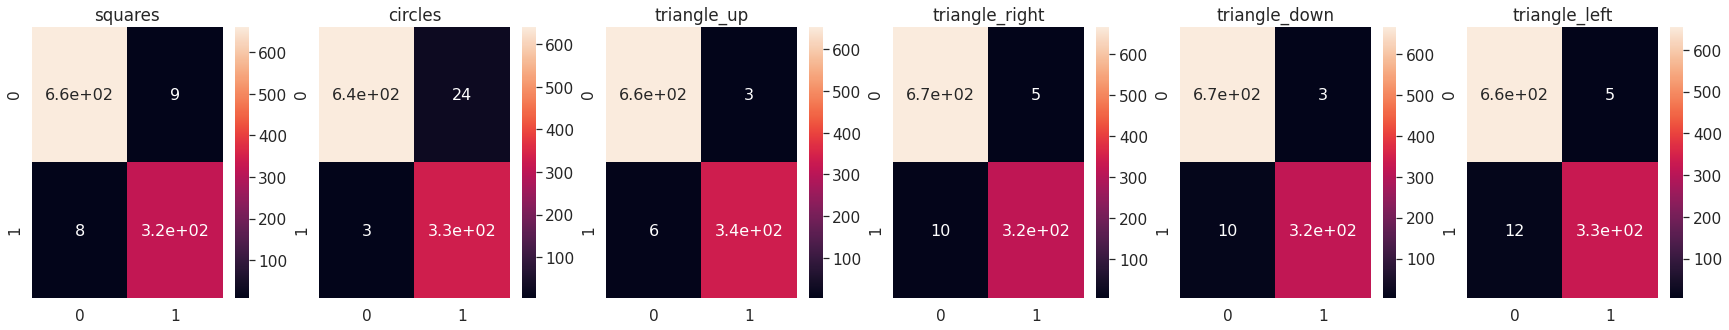

In [27]:
classes = ['squares', 'circles', 'triangle_up', 'triangle_right',
           'triangle_down', 'triangle_left']

sn.set(font_scale=1.4)
fig, axs = plt.subplots(ncols=6, figsize=(30, 5))

for i in range(len(classes)):
    sn.heatmap(confusion[i], annot=True, annot_kws={"size": 16}, ax=axs[i]).set_title(classes[i])

plt.show()